In [66]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from Models import LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import math
import plotly.express as px
import plotly.graph_objects as go


In [67]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler


In [68]:
import rpy2
import rpy2.robjects
from rpy2.robjects.packages import importr

import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

TsAD = importr('otsad')
TSdist = importr('TSdist')

Load and Prepare data to input to LSTM model

In [69]:
filepath = "RELIANCE_2010-01-012021-08-30.csv"
data = pd.read_csv(filepath)
data = data.sort_values('Date')
data.head()

,Date,Open,High,Low,Close,Volume,Name
0,2010-01-04,1091.1,1091.1,1021.85,1075.50,17520006,RELIANCE
1,2010-01-05,1149.9,1149.9,1065.40,1070.70,4890040,RELIANCE
2,2010-01-06,1079.9,1094.5,1070.65,1088.00,5415538,RELIANCE
3,2010-01-07,1088.0,1115.0,1078.00,1106.05,5988404,RELIANCE
4,2010-01-08,1108.0,1113.8,1096.00,1103.15,3453926,RELIANCE


In [70]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [71]:
def splitData(ts):

    test_set_size = int(np.round(0.2*len(ts)))
    train_set = ts[:-test_set_size]    
    test_set = ts[-test_set_size:]

    return train_set, test_set


In [72]:
def modify_test_data(test_set, mean, variance):
    
    noise = np.random.normal(mean, variance, len(test_set))
    modified_test_Set = test_set + noise

    return modified_test_Set

In [73]:
train_set, test_set = splitData(data['Close'].values)

In [74]:
#Normalize data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

In [75]:
# Normalize the training, validation and test set

def normalize_data(train_set, test_set):
    train_norm = scaler.fit_transform(train_set.reshape(-1, 1))
    test_norm = scaler.transform(test_set.reshape(-1, 1))
    
    return train_norm, test_norm

In [76]:
window_size = 20
def prepareDataForTraining(seq):

    x_data = []
    y_data = []
    L = len(seq)
    for i in range(L-window_size):        
        window = seq[i:i+window_size]
        label = seq[i+window_size:i+window_size+1]
        x_data.append(window)
        y_data.append(label)
    return x_data, y_data    

In [77]:
train_norm, test_norm = normalize_data(train_set, test_set)
train_norm, test_norm = normalize_data(train_set, test_set)

x_train, y_train = prepareDataForTraining(train_norm)
x_test, y_test = prepareDataForTraining(test_norm)

x_train = np.asarray(x_train).reshape(-1, window_size, 1)
y_train = np.asarray(y_train).reshape(-1, 1)
x_test = np.asarray(x_test).reshape(-1, window_size, 1)
y_test = np.asarray(y_test).reshape(-1, 1)

In [78]:
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

x_train.shape =  (2296, 20, 1)
y_train.shape =  (2296, 1)
x_test.shape =  (559, 20, 1)
y_test.shape =  (559, 1)


In [79]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Close'], mode='lines', name='closing price'))

fig.update_yaxes(range=[500, 2500])

In [80]:
num_clusters = 7

In [16]:
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=num_clusters,                          
                          metric="dtw",                          
                          max_iter_barycenter=10,
                          random_state=23)

#without normalization
# y_pred = dba_km.fit(x_train_cluster) : Only displays the cluster centres (in red) and the training data is not assigned to any cluster as 
# predict(train) is not done.

y_pred = dba_km.fit_predict(x_train)

DBA k-means


In [17]:
sz = x_train.shape[1]
sz

20

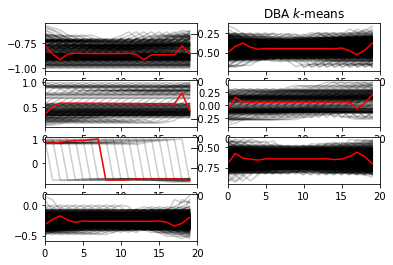

In [18]:
for yi in range(num_clusters):
    plt.subplot(4, 2, 1 + yi)
    for xx in x_train[y_pred == yi]:
        plt.plot(xx.flatten(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    # plt.ylim(-4, 4)
    # plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
    #          transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")

In [19]:
mean = []
std = []
var = []


for i in range(num_clusters):

    cluster = x_train[y_pred == i]
    cluster = np.array(cluster)
    
    mean.append(np.mean(cluster))
    std.append(np.std(cluster))
    var.append(np.var(cluster, dtype=np.float64))
    

stats = pd.DataFrame({'mean': mean,
                    'standard deviation': std,
                    'variance': var

})

clusters = [i for i in range(num_clusters)]

stats.insert(0, 'clusters', clusters)
stats.set_index('clusters', inplace=True)


In [20]:
mean = []
std = []
var = []


for i in range(num_clusters):

    cluster = dba_km.cluster_centers_[i]

    mean.append(np.mean(cluster))
    std.append(np.std(cluster))
    var.append(np.var(cluster, dtype=np.float64))
    

stats_centroid = pd.DataFrame({'centroid mean': mean,
                    'centroid standard deviation': std,
                    'centroid variance': var

})

clusters = [i for i in range(num_clusters)]

stats_centroid.insert(0, 'clusters', clusters)
stats_centroid.set_index('clusters', inplace=True)


In [21]:
stats_centroid

,centroid mean,centroid standard deviation,centroid variance
clusters,,,
0,-0.854018,0.031667,0.001003
1,-0.449602,0.031683,0.001004
2,0.559415,0.075593,0.005714
3,0.053535,0.058203,0.003388
4,-0.050339,0.778360,0.605845
5,-0.641371,0.031621,0.001000
6,-0.263746,0.034687,0.001203


In [81]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

hist = np.zeros(num_epochs)
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    


In [82]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
test_error = mean_absolute_percentage_error(y_test[:,0], y_test_pred[:,0])
accuracy_reg = r2_score(y_test[:, 0], y_test_pred[:, 0])
rmse = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f MAPE' % (test_error))
print(f'R-squared value is {accuracy_reg}')
print('RMSE: ', rmse)

Test Score: 0.05 MAPE
R-squared value is 0.8867951845393981
RMSE:  123.6272315584738


In [83]:
torch.save(model, 'lstm_model.pt')

#### Predict the cluster for test data

In [84]:
res = dba_km.predict(x_test)

In [85]:
res

array([2, 2, 2, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [26]:
np.where(res == 6)

(array([209, 210, 211, 212, 213, 214, 215, 216, 217, 218]),)

In [86]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Close'][-len(test_set):], mode='lines', name='closing price'))

In [48]:
# x_test[150] contains shape (20,1)
t1 = np.array(x_test[150])

In [49]:
t2 = np.array(x_test[204])

#### Compute mean relative change for different test sequences

In [87]:
t = [150, 204, 264, 245, 180, 255, 195, 50, 284, 400]
mean = []
std = []
var = []
cluster_assigned = []
cluster_mean = []


for i in t:

    data = np.array(x_test[i])

    mean.append(np.mean(data))
    std.append(np.std(data))
    var.append(np.var(data, dtype=np.float64))
    cluster_assigned.append(res[i])

    cluster_mean.append(np.mean(dba_km.cluster_centers_[res[i]]))

tests = pd.DataFrame({'test values': t,
                    'mean': mean,
                    'standard deviation': std,
                    'variance': var,
                    'cluster_assigned': cluster_assigned,
                    'cluster_mean': cluster_mean

})
tests
    

,test values,mean,standard deviation,variance,cluster_assigned,cluster_mean
0,150,0.797705,0.059571,0.003549,2,0.559415
1,204,0.003434,0.361861,0.130943,3,0.053535
2,264,0.892911,0.172123,0.029626,2,0.559415
3,245,0.616237,0.087735,0.007697,2,0.559415
4,180,0.612644,0.085074,0.007238,2,0.559415
5,255,0.674687,0.120417,0.014500,2,0.559415
6,195,0.449179,0.221007,0.048844,2,0.559415
7,50,0.125672,0.116218,0.013507,3,0.053535
8,284,1.379133,0.177992,0.031681,2,0.559415
9,400,1.686227,0.046010,0.002117,2,0.559415


In [88]:
tests_mean = tests.copy()

In [89]:
tests_mean['mean diff'] = (tests_mean['mean'] - tests_mean['cluster_mean'])
tests_mean

,test values,mean,standard deviation,variance,cluster_assigned,cluster_mean,mean diff
0,150,0.797705,0.059571,0.003549,2,0.559415,0.238291
1,204,0.003434,0.361861,0.130943,3,0.053535,-0.050101
2,264,0.892911,0.172123,0.029626,2,0.559415,0.333496
3,245,0.616237,0.087735,0.007697,2,0.559415,0.056823
4,180,0.612644,0.085074,0.007238,2,0.559415,0.053229
5,255,0.674687,0.120417,0.014500,2,0.559415,0.115272
6,195,0.449179,0.221007,0.048844,2,0.559415,-0.110236
7,50,0.125672,0.116218,0.013507,3,0.053535,0.072138
8,284,1.379133,0.177992,0.031681,2,0.559415,0.819718
9,400,1.686227,0.046010,0.002117,2,0.559415,1.126812


In [90]:
tests_mean['mean relative change'] = tests_mean['mean diff'] / abs(tests_mean['cluster_mean'])
tests_mean

,test values,mean,standard deviation,variance,cluster_assigned,cluster_mean,mean diff,mean relative change
0,150,0.797705,0.059571,0.003549,2,0.559415,0.238291,0.425964
1,204,0.003434,0.361861,0.130943,3,0.053535,-0.050101,-0.935849
2,264,0.892911,0.172123,0.029626,2,0.559415,0.333496,0.596152
3,245,0.616237,0.087735,0.007697,2,0.559415,0.056823,0.101575
4,180,0.612644,0.085074,0.007238,2,0.559415,0.053229,0.095152
5,255,0.674687,0.120417,0.014500,2,0.559415,0.115272,0.206059
6,195,0.449179,0.221007,0.048844,2,0.559415,-0.110236,-0.197056
7,50,0.125672,0.116218,0.013507,3,0.053535,0.072138,1.347491
8,284,1.379133,0.177992,0.031681,2,0.559415,0.819718,1.465314
9,400,1.686227,0.046010,0.002117,2,0.559415,1.126812,2.014271


(0.0, 20.0)

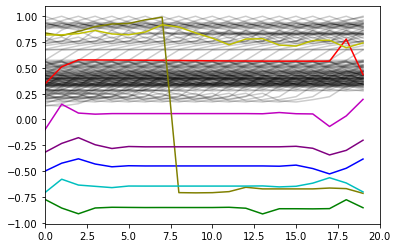

In [32]:
# plot x_test[150] 

for xx in x_train[y_pred == 2]:
    plt.plot(xx.flatten(), "k-", alpha=.2)
plt.plot(dba_km.cluster_centers_[2].ravel(), "r-")
plt.plot(dba_km.cluster_centers_[0].ravel(), "g-")
plt.plot(dba_km.cluster_centers_[1].ravel(), "b-")
plt.plot(dba_km.cluster_centers_[3].ravel(), "m-")
plt.plot(dba_km.cluster_centers_[4].ravel(), "olive")
plt.plot(dba_km.cluster_centers_[5].ravel(), "c")
plt.plot(dba_km.cluster_centers_[6].ravel(), "purple")
plt.plot(x_test[150], "y-")
plt.xlim(0, sz)

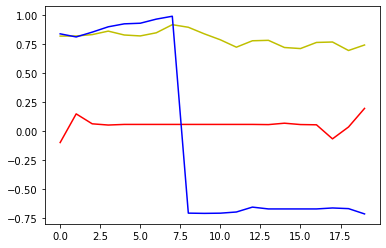

In [63]:
plt.plot(x_test[150], "y-")
plt.plot(dba_km.cluster_centers_[3].ravel(), "r-")
plt.plot(dba_km.cluster_centers_[4].ravel(), "b-")

(0.0, 20.0)

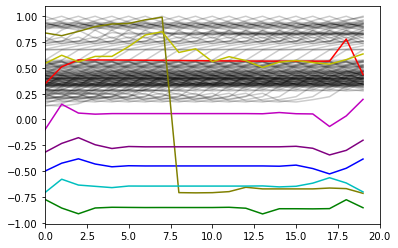

In [56]:
# plot x_test[245] 

for xx in x_train[y_pred == 2]:
    plt.plot(xx.flatten(), "k-", alpha=.2)
plt.plot(dba_km.cluster_centers_[2].ravel(), "r-")
plt.plot(dba_km.cluster_centers_[0].ravel(), "g-")
plt.plot(dba_km.cluster_centers_[1].ravel(), "b-")
plt.plot(dba_km.cluster_centers_[3].ravel(), "m-")
plt.plot(dba_km.cluster_centers_[4].ravel(), "olive")
plt.plot(dba_km.cluster_centers_[5].ravel(), "c")
plt.plot(dba_km.cluster_centers_[6].ravel(), "purple")
plt.plot(x_test[245], "y-")
plt.xlim(0, sz)

(0.0, 20.0)

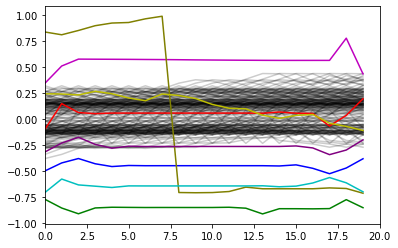

In [58]:
# plot x_test[50] 

for xx in x_train[y_pred == 3]:
    plt.plot(xx.flatten(), "k-", alpha=.2)
plt.plot(dba_km.cluster_centers_[3].ravel(), "r-")
plt.plot(dba_km.cluster_centers_[0].ravel(), "g-")
plt.plot(dba_km.cluster_centers_[1].ravel(), "b-")
plt.plot(dba_km.cluster_centers_[2].ravel(), "m-")
plt.plot(dba_km.cluster_centers_[4].ravel(), "olive")
plt.plot(dba_km.cluster_centers_[5].ravel(), "c")
plt.plot(dba_km.cluster_centers_[6].ravel(), "purple")
plt.plot(x_test[50], "y-")
plt.xlim(0, sz)

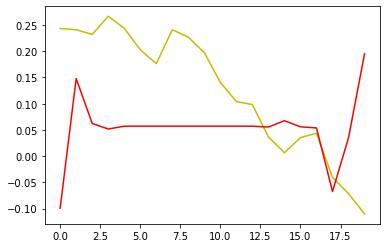

In [59]:
plt.plot(x_test[50], "y-")
plt.plot(dba_km.cluster_centers_[3].ravel(), "r-")

(0.0, 20.0)

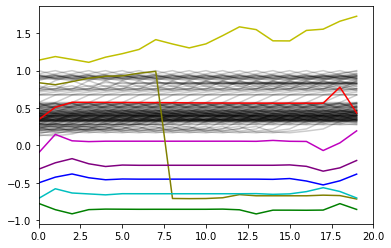

In [60]:
# plot x_test[284] 

for xx in x_train[y_pred == 2]:
    plt.plot(xx.flatten(), "k-", alpha=.2)
plt.plot(dba_km.cluster_centers_[2].ravel(), "r-")
plt.plot(dba_km.cluster_centers_[0].ravel(), "g-")
plt.plot(dba_km.cluster_centers_[1].ravel(), "b-")
plt.plot(dba_km.cluster_centers_[3].ravel(), "m-")
plt.plot(dba_km.cluster_centers_[4].ravel(), "olive")
plt.plot(dba_km.cluster_centers_[5].ravel(), "c")
plt.plot(dba_km.cluster_centers_[6].ravel(), "purple")
plt.plot(x_test[284], "y-")
plt.xlim(0, sz)

(0.0, 20.0)

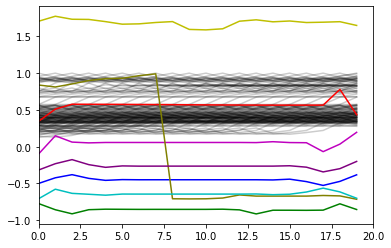

In [61]:
# plot x_test[400]

for xx in x_train[y_pred == 2]:
    plt.plot(xx.flatten(), "k-", alpha=.2)
plt.plot(dba_km.cluster_centers_[2].ravel(), "r-")
plt.plot(dba_km.cluster_centers_[0].ravel(), "g-")
plt.plot(dba_km.cluster_centers_[1].ravel(), "b-")
plt.plot(dba_km.cluster_centers_[3].ravel(), "m-")
plt.plot(dba_km.cluster_centers_[4].ravel(), "olive")
plt.plot(dba_km.cluster_centers_[5].ravel(), "c")
plt.plot(dba_km.cluster_centers_[6].ravel(), "purple")
plt.plot(x_test[400], "y-")
plt.xlim(0, sz)

#### Compute difference between maximum std of assigned cluster and various test sequences

In [91]:
tests_std_var = tests.copy()
tests_std_var

,test values,mean,standard deviation,variance,cluster_assigned,cluster_mean
0,150,0.797705,0.059571,0.003549,2,0.559415
1,204,0.003434,0.361861,0.130943,3,0.053535
2,264,0.892911,0.172123,0.029626,2,0.559415
3,245,0.616237,0.087735,0.007697,2,0.559415
4,180,0.612644,0.085074,0.007238,2,0.559415
5,255,0.674687,0.120417,0.014500,2,0.559415
6,195,0.449179,0.221007,0.048844,2,0.559415
7,50,0.125672,0.116218,0.013507,3,0.053535
8,284,1.379133,0.177992,0.031681,2,0.559415
9,400,1.686227,0.046010,0.002117,2,0.559415


In [92]:
for clustercentre in tests_std_var['cluster_assigned']:
    print(type(clustercentre))
    print(clustercentre)
    break

<class 'int'>
2


In [93]:
cluster_std = []
cluster_var = []

for clustercentre in tests_std_var['cluster_assigned']:

    cluster = x_train[y_pred == clustercentre]
    cluster =  np.array(cluster)

    std = np.std(cluster, axis=1)
    var = np.var(cluster, axis=1)

    std = std.flatten()
    var = var.flatten()

    std_max_index = np.argmax(std)
    std_max = std.max()

    var_max_index = np.argmax(var)
    var_max = var.max()

    cluster_std.append(std_max)
    cluster_var.append(var_max)

In [94]:
tests_std_var = tests_std_var.assign(**{'cluster std': cluster_std, 'cluster variance':cluster_var})
tests_std_var

,test values,mean,standard deviation,variance,cluster_assigned,cluster_mean,cluster std,cluster variance
0,150,0.797705,0.059571,0.003549,2,0.559415,0.149101,0.022231
1,204,0.003434,0.361861,0.130943,3,0.053535,0.212500,0.045156
2,264,0.892911,0.172123,0.029626,2,0.559415,0.149101,0.022231
3,245,0.616237,0.087735,0.007697,2,0.559415,0.149101,0.022231
4,180,0.612644,0.085074,0.007238,2,0.559415,0.149101,0.022231
5,255,0.674687,0.120417,0.014500,2,0.559415,0.149101,0.022231
6,195,0.449179,0.221007,0.048844,2,0.559415,0.149101,0.022231
7,50,0.125672,0.116218,0.013507,3,0.053535,0.212500,0.045156
8,284,1.379133,0.177992,0.031681,2,0.559415,0.149101,0.022231
9,400,1.686227,0.046010,0.002117,2,0.559415,0.149101,0.022231


In [95]:
tests_std_var['max std diff'] = (tests_std_var['standard deviation'] - tests_std_var['cluster std'])
tests_std_var['std reltive change'] = tests_std_var['max std diff'] / abs(tests_std_var['cluster std'])
tests_std_var

,test values,mean,standard deviation,variance,cluster_assigned,cluster_mean,cluster std,cluster variance,max std diff,std reltive change
0,150,0.797705,0.059571,0.003549,2,0.559415,0.149101,0.022231,-0.089529,-0.600462
1,204,0.003434,0.361861,0.130943,3,0.053535,0.212500,0.045156,0.149361,0.702874
2,264,0.892911,0.172123,0.029626,2,0.559415,0.149101,0.022231,0.023022,0.154404
3,245,0.616237,0.087735,0.007697,2,0.559415,0.149101,0.022231,-0.061366,-0.411571
4,180,0.612644,0.085074,0.007238,2,0.559415,0.149101,0.022231,-0.064027,-0.429418
5,255,0.674687,0.120417,0.014500,2,0.559415,0.149101,0.022231,-0.028684,-0.192377
6,195,0.449179,0.221007,0.048844,2,0.559415,0.149101,0.022231,0.071906,0.482264
7,50,0.125672,0.116218,0.013507,3,0.053535,0.212500,0.045156,-0.096282,-0.453091
8,284,1.379133,0.177992,0.031681,2,0.559415,0.149101,0.022231,0.028891,0.193768
9,400,1.686227,0.046010,0.002117,2,0.559415,0.149101,0.022231,-0.103091,-0.691419


In [96]:
tests_std_var['max var diff'] = (tests_std_var['variance'] - tests_std_var['cluster variance'])
tests_std_var['var reltive change'] = tests_std_var['max var diff'] / abs(tests_std_var['cluster variance'])
tests_std_var

,test values,mean,standard deviation,variance,cluster_assigned,cluster_mean,cluster std,cluster variance,max std diff,std reltive change,max var diff,var reltive change
0,150,0.797705,0.059571,0.003549,2,0.559415,0.149101,0.022231,-0.089529,-0.600462,-0.018682,-0.840369
1,204,0.003434,0.361861,0.130943,3,0.053535,0.212500,0.045156,0.149361,0.702874,0.085787,1.899780
2,264,0.892911,0.172123,0.029626,2,0.559415,0.149101,0.022231,0.023022,0.154404,0.007395,0.332650
3,245,0.616237,0.087735,0.007697,2,0.559415,0.149101,0.022231,-0.061366,-0.411571,-0.014534,-0.653752
4,180,0.612644,0.085074,0.007238,2,0.559415,0.149101,0.022231,-0.064027,-0.429418,-0.014993,-0.674437
5,255,0.674687,0.120417,0.014500,2,0.559415,0.149101,0.022231,-0.028684,-0.192377,-0.007731,-0.347745
6,195,0.449179,0.221007,0.048844,2,0.559415,0.149101,0.022231,0.071906,0.482264,0.026613,1.197106
7,50,0.125672,0.116218,0.013507,3,0.053535,0.212500,0.045156,-0.096282,-0.453091,-0.031650,-0.700891
8,284,1.379133,0.177992,0.031681,2,0.559415,0.149101,0.022231,0.028891,0.193768,0.009450,0.425081
9,400,1.686227,0.046010,0.002117,2,0.559415,0.149101,0.022231,-0.103091,-0.691419,-0.020114,-0.904778


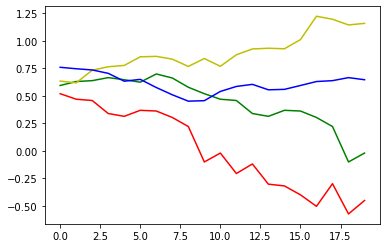

In [39]:
plt.plot(x_test[195], 'g')
plt.plot(x_test[204], 'r')
plt.plot(x_test[264], 'y')
plt.plot(x_test[180], 'b')

<ul>
    <li>Relative change mean > 1 indicates an increasing trend (gradual increase), a shift.</li>
    <li> Relative change varainace > 1 indicates a sudden noise/disturbance in the sequence</li>
</ul>

### Create a synthetic time sequence of 20 timesteps with high standard deviation (sudden jump)

In [40]:
t1 = np.arange(-1.0, -0.5, 0.05)
np.append(t1, 1)
len(t1)

10

In [41]:
t2 = np.arange(1.1, 1.6, 0.05)
len(t2)

10

In [42]:
final = np.concatenate((t1,t2))
final

array([-1.  , -0.95, -0.9 , -0.85, -0.8 , -0.75, -0.7 , -0.65, -0.6 ,
       -0.55,  1.1 ,  1.15,  1.2 ,  1.25,  1.3 ,  1.35,  1.4 ,  1.45,
        1.5 ,  1.55])

In [43]:
len(final)

20

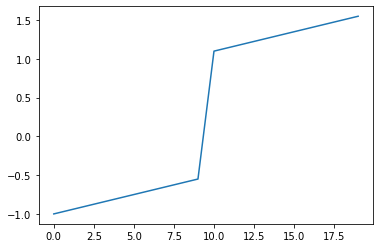

In [44]:
plt.plot(final)

In [45]:
np.std(final), np.mean(final), np.var(final)

(1.0597759197113323, 0.27500000000000024, 1.1231250000000002)

In [46]:
final = final.reshape(-1, 20, 1)

In [47]:
final_cluster = dba_km.predict(final)

In [48]:
final_cluster

array([2])

#### Compute the relative change in mean, std, var for this synthetic data point that has a sudden jump (therefore, high std).

In [49]:
mean_final = (np.mean(final) - tests_std_var['cluster_mean'][0]) / abs(tests_std_var['cluster_mean'][0])
std_final = ((np.std(final) - tests_std_var['cluster std'][0])) / abs(tests_std_var['cluster std'][0])
variance_final = ((np.var(final) - tests_std_var['cluster variance'][0])) / abs(tests_std_var['cluster variance'][0])

In [50]:
print("mean of synthetic time sequence:", mean_final)
print("std of synthetic time sequence:", std_final)
print("variance of synthetic time sequence:", variance_final)

mean of synthetic time sequence: -0.508414696544433
std of synthetic time sequence: 6.107783930291172
variance of synthetic time sequence: 49.52059417881317


<ul>
    <li>The standard deviation is minimal as long as the signal is steady (with some noise). The standard deviation will increase if there is a jump in the signal.</li>
</ul>

### Create another time sequence with sudden fall in values

In [51]:
t2 = np.arange(1, 0.8, -0.025)
len(t2)

8

In [52]:
t2


array([1.   , 0.975, 0.95 , 0.925, 0.9  , 0.875, 0.85 , 0.825])

In [53]:
t2 = np.append(t2, -0.8)

In [54]:
t1 = np.arange(-0.75, -0.64, 0.01)
len(t1)

11

In [55]:
t1

array([-0.75, -0.74, -0.73, -0.72, -0.71, -0.7 , -0.69, -0.68, -0.67,
       -0.66, -0.65])

In [56]:
final_down = np.concatenate((t2, t1))
final_down

array([ 1.   ,  0.975,  0.95 ,  0.925,  0.9  ,  0.875,  0.85 ,  0.825,
       -0.8  , -0.75 , -0.74 , -0.73 , -0.72 , -0.71 , -0.7  , -0.69 ,
       -0.68 , -0.67 , -0.66 , -0.65 ])

In [57]:
len(final_down)

20

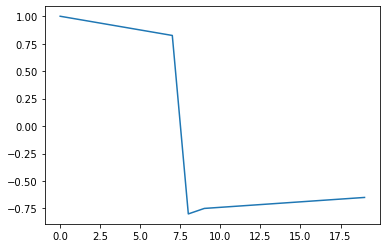

In [58]:
plt.plot(final_down)

In [59]:
final_down = final_down.reshape(-1, 20, 1)

In [60]:
final_down_cluster = dba_km.predict(final_down)
final_down_cluster

array([4])

In [61]:
cluster4_mean = np.mean(dba_km.cluster_centers_[4])
cluster4 = x_train[y_pred == 4]
cluster4 =  np.array(cluster4)

std = np.std(cluster4, axis=1)
var = np.var(cluster4, axis=1)

std = std.flatten()
var = var.flatten()

std_max_index = np.argmax(std)
std_max = std.max()

var_max_index = np.argmax(var)
var_max = var.max()


In [62]:
np.mean(final_down), cluster4_mean

(-0.06000000000000001, -0.05033888109317528)

In [64]:
mean_final_down = ((np.mean(final_down)) - cluster4_mean) / abs(cluster4_mean)
std_final_down = (np.std(final_down) - std_max) / abs(std_max)
variance_final_down = (np.var(final_down) - var_max) / abs(var_max)

In [65]:
print("mean of synthetic time sequence:", mean_final_down)
print("std of synthetic time sequence:", std_final_down)
print("variance of synthetic time sequence:", variance_final_down)

mean of synthetic time sequence: -0.1919216060631618
std of synthetic time sequence: 0.021805077864399593
variance of synthetic time sequence: 0.044085643913221895
